In [103]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

In [104]:
from sklearn.metrics import classification_report

In [105]:
import pandas as pd
df=pd.read_csv("source_X.csv",encoding="utf-8")

df=df.dropna(axis=0)


In [106]:
df.shape

(8000, 153)

In [107]:
dfnew=pd.read_csv("source_y.csv",encoding="utf-8")

df=pd.concat([df,dfnew],axis=1)

df["happiness"].value_counts()

df["happiness"]=df["happiness"].map({1:0,2:1,3:2,4:3,5:4})
df=pd.concat([df[df["happiness"]==3].sample(frac=0.3),df[df["happiness"]!=3]],axis=0)
label=df["happiness"]
df["newcol_1"]=1
df["newcol_2"]=0
del df["happiness"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

In [108]:
col=[]
for i in df.columns:
    col.append(i.split("_")[0])

import numpy as np
l=[]
first=0
last=0
colname=[]
for ind,i in enumerate(col):
    last+=1
    if last==len(col):
         
         print (df[df.columns[first:last]])
         colname.append(df.columns[first:last][0][:-2])
         l.append(np.argmax(df[df.columns[first:last]].values,axis=1))
         break
    if col[last]!=col[last-1]:
         print (df[df.columns[first:last]])
         colname.append(df.columns[first:last][0][:-2])
#          print (np.argmax(df[df.columns[first:last]].values,axis=1).max())
         l.append(np.argmax(df[df.columns[first:last]].values,axis=1))
         first=last
         last=last+1
         
#          break

      gender_0  gender_1
136          0         1
7738         0         1
3321         1         0
1896         0         1
3597         0         1
...        ...       ...
7987         0         1
7992         1         0
7995         0         1
7996         1         0
7998         1         0

[4627 rows x 2 columns]
      age_group_1  age_group_2  age_group_3  age_group_4  age_group_5
136             1            0            0            0            0
7738            0            0            0            0            1
3321            0            0            0            1            0
1896            1            0            0            0            0
3597            0            1            0            0            0
...           ...          ...          ...          ...          ...
7987            0            0            1            0            0
7992            0            0            1            0            0
7995            0            1            0  

In [109]:
colname

['gender',
 'age_group',
 'edu_group',
 'bmi_cut',
 'edu_status_1',
 'health',
 'marital',
 'political',
 'religion',
 'hukou',
 'nationality',
 'newcol']

In [137]:
colname[4]='edu_status'
colname[1]='age'
colname[2]='edu'
colname[3]='bmi'


In [138]:
colname

['gender',
 'age',
 'edu',
 'bmi',
 'edu_status',
 'health',
 'marital',
 'political',
 'religion',
 'hukou',
 'nationality',
 'newcol']

In [112]:
import pandas as pd

dfemd=pd.DataFrame()

embed_num=[]
for ind,i in enumerate(l):
    dfemd[ind]=i
    embed_num.append(len(dfemd[ind].unique())+2)

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import re
from tensorflow.keras.callbacks import Callback
import tensorflow
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import KFold


def get_deep_wide_net():
    embedall=[]
    for ind,i in enumerate(dfemd.columns):
         embedall.append(Embedding(100, 128, input_length=1,
                      trainable=True))

    len(embedall)

    input1 = Input(shape=(X_train.shape[1], )) #模型的入口,设置输入的维度
    embedl=[]
    for i in range(len(embedall)):
        embedl.append(Input(shape=(1,)))

    l=[]
    for i in range(len(embedl)):
        l.append(embedall[i](embedl[i]))

    embedcat=Concatenate()(l)

    embedcat=Dense(128,activation="relu")(embedcat)

    floatdense=Dense(128)(input1)
    embedcatnew=Flatten()(embedcat)

    last=Concatenate()([embedcatnew,floatdense])
    output1=Dense(128)(last)
    output = Dense(5, activation='softmax')(output1)#softmax层

    model = Model(inputs=[input1]+embedl, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#定义损失函数，优化器，评分标准
    model.summary()
    return model

In [113]:
from sklearn import metrics
recal_all=[]
pre_all=[]
f1_all=[]
acc_all=[]
f1_micro=[]

t_recal_all=[]
t_pre_all=[]
t_f1_all=[]
t_acc_all=[]
t_f1_micro=[]
k=5
kf = KFold(n_splits=k, shuffle=True)
#     tmppre=np.zeros(y.shape)
ind=0
for (train, test) in  kf.split(df.values):
        print ("fold",ind,"start")
        X_train=df.values[train]
        y_train=label.values[train]
        emd_train=dfemd.values[train]
        emd_test=dfemd.values[test]
        train_all=[]
        train_all.append(X_train)
        for ind in range(emd_train.shape[1]):
            train_all.append(np.expand_dims(emd_train[:,ind],axis=1))
            
       
        X_test=df.values[test]
        testall=[]
        testall.append(X_test)
        for ind in range(emd_test.shape[1]):
            testall.append(np.expand_dims(emd_test[:,ind],axis=1))
#         break
        y_test=label.values[test]
        X_train=X_train.reshape(X_train.shape[0],X_train.shape[1])
        X_test=X_test.reshape(X_test.shape[0],X_test.shape[1])
        
        callbacks = [EarlyStopping(monitor='val_acc', verbose=1, patience=1000),
             ModelCheckpoint("model_wide_class_{}.hdf5".format(ind), monitor='val_acc',
                             mode='max', verbose=0, save_best_only=True,save_weights_only=True)]
        model_new = get_deep_wide_net()

        model_new.fit(train_all, y_train, epochs=20, batch_size=16, validation_data=(testall, y_test) ,callbacks=callbacks)
        model_new.load_weights("model_wide_class_{}.hdf5".format(ind)) #加载最优模型
        ypre=np.argmax(model_new.predict(testall),axis=-1)
        tmpacc=accuracy_score(y_test,ypre)
        tmppre=precision_score(y_test,ypre,average="macro")
        tmprecal=recall_score(y_test,ypre,average="macro")
        tmpf1=f1_score(y_test,ypre,average="macro")
        tmpf1_mic=f1_score(y_test,ypre,average="micro")
        print ("fold_{} acc: {} precision: {} recall : {} ,mac f1: {} ,mic f1: {}".format(ind,tmpacc,tmppre,tmprecal,tmpf1,tmpf1_mic))
        print ("test reprot: ",classification_report(y_test,ypre,digits=4))
        recal_all.append(tmprecal)
        acc_all.append(tmpacc)
        f1_all.append(tmpf1)
        pre_all.append(tmppre)
        f1_micro.append(tmpf1_mic)
        ind+=1

        ypre=np.argmax(model_new.predict(train_all),axis=-1)
        tmpacc=accuracy_score(y_train,ypre)
        tmppre=precision_score(y_train,ypre,average="macro")
        tmprecal=recall_score(y_train,ypre,average="macro")
        tmpf1=f1_score(y_train,ypre,average="macro")
        tmpf1_mic=f1_score(y_train,ypre,average="micro")
        print ("fold_{} train_acc: {} train_precision: {} train_recall : {},mac f1: {} ,mic f1: {}".format(ind,tmpacc,tmppre,tmprecal,tmpf1,tmpf1_mic))
        print ("train reprot: ",classification_report(y_train,ypre,digits=4))
        t_recal_all.append(tmprecal)
        t_acc_all.append(tmpacc)
        t_f1_all.append(tmpf1)
        t_pre_all.append(tmppre)
        t_f1_micro.append(tmpf1_mic)
    
print ("max acc:{}".format(max(acc_all)))
print ("min acc:{}".format(min(acc_all)))
print ("mean acc:{}".format(sum(acc_all)/5))


print ("max precision:{}".format(max(pre_all)))
print ("min precision:{}".format(min(pre_all)))
print ("mean precision:{}".format(sum(pre_all)/5))

print ("max recall:{}".format(max(recal_all)))
print ("min recall:{}".format(min(recal_all)))
print ("mean recall:{}".format(sum(recal_all)/5))



print ("max mac f1:{}".format(max(f1_all)))
print ("min mac f1:{}".format(min(f1_all)))
print ("mean mac f1:{}".format(sum(f1_all)/5))

print ("max mic f1:{}".format(max(f1_micro)))
print ("min mic f1:{}".format(min(f1_micro)))
print ("mean mic f1:{}".format(sum(f1_micro)/5))


print ("train max acc:{}".format(max(t_acc_all)))
print ("train min acc:{}".format(min(t_acc_all)))
print ("train mean acc:{}".format(sum(t_acc_all)/5))



print ("train max precision:{}".format(max(t_pre_all)))
print ("train min precision:{}".format(min(t_pre_all)))
print ("train mean precision:{}".format(sum(t_pre_all)/5))


print ("train max recall:{}".format(max(t_recal_all)))
print ("train min recall:{}".format(min(t_recal_all)))
print ("train mean recall:{}".format(sum(t_recal_all)/5))


print ("train max mac f1:{}".format(max(t_f1_all)))
print ("train min mac f1:{}".format(min(t_f1_all)))
print ("train mean mac f1:{}".format(sum(t_f1_all)/5))


print ("train max mic f1:{}".format(max(t_f1_micro)))
print ("train min mic f1:{}".format(min(t_f1_micro)))
print ("train mean mic f1:{}".format(sum(t_f1_micro)/5))

fold 0 start
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_197 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_198 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_199 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_200 (InputLayer)          [(None, 1)]          0                                            
______________________________________________________________________________

Epoch 2/20
3701/3701 [==============================] - 1s 345us/sample - loss: 1.3010 - acc: 0.4039 - val_loss: 1.3613 - val_acc: 0.3661
Epoch 3/20
3701/3701 [==============================] - 1s 374us/sample - loss: 1.2899 - acc: 0.4223 - val_loss: 1.3471 - val_acc: 0.3715
Epoch 4/20
3701/3701 [==============================] - 1s 403us/sample - loss: 1.2735 - acc: 0.4229 - val_loss: 1.3856 - val_acc: 0.3596
Epoch 5/20
3701/3701 [==============================] - 1s 384us/sample - loss: 1.2718 - acc: 0.4288 - val_loss: 1.3365 - val_acc: 0.3737
Epoch 6/20
3701/3701 [==============================] - 1s 368us/sample - loss: 1.2593 - acc: 0.4361 - val_loss: 1.3393 - val_acc: 0.3747
Epoch 7/20
3701/3701 [==============================] - 1s 331us/sample - loss: 1.2455 - acc: 0.4439 - val_loss: 1.3676 - val_acc: 0.3747
Epoch 8/20
3701/3701 [==============================] - 1s 349us/sample - loss: 1.2319 - acc: 0.4483 - val_loss: 1.3552 - val_acc: 0.3769
Epoch 9/20
3701/3701 [============

Epoch 1/20
3701/3701 [==============================] - 8s 2ms/sample - loss: 1.3741 - acc: 0.3596 - val_loss: 1.2971 - val_acc: 0.3866
Epoch 2/20
3701/3701 [==============================] - 1s 349us/sample - loss: 1.3111 - acc: 0.3994 - val_loss: 1.3160 - val_acc: 0.3985
Epoch 3/20
3701/3701 [==============================] - 1s 369us/sample - loss: 1.2974 - acc: 0.4077 - val_loss: 1.2947 - val_acc: 0.3996
Epoch 4/20
3701/3701 [==============================] - 1s 360us/sample - loss: 1.2899 - acc: 0.4145 - val_loss: 1.2988 - val_acc: 0.4006
Epoch 5/20
3701/3701 [==============================] - 1s 362us/sample - loss: 1.2755 - acc: 0.4231 - val_loss: 1.3070 - val_acc: 0.4039
Epoch 6/20
3701/3701 [==============================] - 1s 338us/sample - loss: 1.2665 - acc: 0.4256 - val_loss: 1.3096 - val_acc: 0.3855
Epoch 7/20
3701/3701 [==============================] - 1s 320us/sample - loss: 1.2557 - acc: 0.4404 - val_loss: 1.3102 - val_acc: 0.3963
Epoch 8/20
3701/3701 [==============

Epoch 1/20
3702/3702 [==============================] - 8s 2ms/sample - loss: 1.3563 - acc: 0.3536 - val_loss: 1.3141 - val_acc: 0.3946
Epoch 2/20
3702/3702 [==============================] - 1s 377us/sample - loss: 1.3113 - acc: 0.4001 - val_loss: 1.3148 - val_acc: 0.4032
Epoch 3/20
3702/3702 [==============================] - 1s 349us/sample - loss: 1.2957 - acc: 0.4022 - val_loss: 1.3167 - val_acc: 0.4086
Epoch 4/20
3702/3702 [==============================] - 1s 334us/sample - loss: 1.2862 - acc: 0.4114 - val_loss: 1.3334 - val_acc: 0.3881
Epoch 5/20
3702/3702 [==============================] - 1s 389us/sample - loss: 1.2739 - acc: 0.4046 - val_loss: 1.3158 - val_acc: 0.4119
Epoch 6/20
3702/3702 [==============================] - 1s 338us/sample - loss: 1.2636 - acc: 0.4303 - val_loss: 1.3402 - val_acc: 0.3805
Epoch 7/20
3702/3702 [==============================] - 1s 338us/sample - loss: 1.2492 - acc: 0.4211 - val_loss: 1.3708 - val_acc: 0.3643
Epoch 8/20
3702/3702 [==============

Epoch 1/20
3702/3702 [==============================] - 9s 2ms/sample - loss: 1.3599 - acc: 0.3617 - val_loss: 1.3344 - val_acc: 0.3859
Epoch 2/20
3702/3702 [==============================] - 1s 338us/sample - loss: 1.3002 - acc: 0.4001 - val_loss: 1.3739 - val_acc: 0.3795
Epoch 3/20
3702/3702 [==============================] - 1s 334us/sample - loss: 1.2869 - acc: 0.4076 - val_loss: 1.3317 - val_acc: 0.3827
Epoch 4/20
3702/3702 [==============================] - 1s 339us/sample - loss: 1.2760 - acc: 0.4176 - val_loss: 1.3565 - val_acc: 0.3816
Epoch 5/20
3702/3702 [==============================] - 1s 355us/sample - loss: 1.2700 - acc: 0.4187 - val_loss: 1.3261 - val_acc: 0.4076
Epoch 6/20
3702/3702 [==============================] - 1s 355us/sample - loss: 1.2619 - acc: 0.4192 - val_loss: 1.3356 - val_acc: 0.4119
Epoch 7/20
3702/3702 [==============================] - 1s 340us/sample - loss: 1.2475 - acc: 0.4379 - val_loss: 1.3394 - val_acc: 0.3957
Epoch 8/20
3702/3702 [==============

Epoch 1/20
3702/3702 [==============================] - 9s 2ms/sample - loss: 1.3514 - acc: 0.3666 - val_loss: 1.3518 - val_acc: 0.3632
Epoch 2/20
3702/3702 [==============================] - 1s 373us/sample - loss: 1.2991 - acc: 0.4014 - val_loss: 1.3460 - val_acc: 0.3741
Epoch 3/20
3702/3702 [==============================] - 1s 330us/sample - loss: 1.2860 - acc: 0.4071 - val_loss: 1.3676 - val_acc: 0.3708
Epoch 4/20
3702/3702 [==============================] - 1s 328us/sample - loss: 1.2722 - acc: 0.4249 - val_loss: 1.3620 - val_acc: 0.3654
Epoch 5/20
3702/3702 [==============================] - 1s 356us/sample - loss: 1.2713 - acc: 0.4165 - val_loss: 1.3893 - val_acc: 0.3395
Epoch 6/20
3702/3702 [==============================] - 1s 334us/sample - loss: 1.2585 - acc: 0.4298 - val_loss: 1.3548 - val_acc: 0.3730
Epoch 7/20
3702/3702 [==============================] - 1s 354us/sample - loss: 1.2502 - acc: 0.4333 - val_loss: 1.3909 - val_acc: 0.3665
Epoch 8/20
3702/3702 [==============

In [114]:
import random

In [115]:
#model_new.load_weights("model_wide_class_{}.hdf5".format(ind))

In [116]:
from tqdm import tqdm
def get_important(col="gender",M=100,I=100):
    
    sumall=[]
    for num in tqdm(range(I)):
        num_fea=colname.index(col)+1
        for i in random.sample(list(range(len(train_all))),1):  # (1)随机采样一条样本xi
        #     print (i)
            xi=[]
            for j in range(len(train_all)):
                xi.append(train_all[j][i:i+1])
        tmp1=[]
        for i in range(M):
            for i in random.sample(list(range(len(train_all))),1): #(2)随机采样一条样本z
        #         print (i)
                z=[]
                for j in range(len(train_all)):
                    z.append(train_all[j][i:i+1])
            shutuf=random.sample(list(range(len(colname))),len(colname)) #(3)随机采样1到n排列 

            x_=[xi[0]]+list(np.array(xi[1:])[shutuf])#（4）
            z_=[z[0]]+list(np.array(z[1:])[shutuf])#(5)

            x_1=x_[:1+num_fea]+z_[1+num_fea:]
            x_2=x_[:num_fea]+z_[num_fea:] #(6)

        #     print (abs(np.mean(model_new.predict(x_1)-model_new.predict(x_2),axis=1)[0])) #(7)
            tmp1.append(abs(model_new.predict(x_1)-model_new.predict(x_2)))
        sumall.append(tmp1)
    return np.mean(np.array(sumall),axis=0)[0]

In [117]:
fea_import=[]
for col in colname:
    tmp=get_important(col,M=40,I=40)
    fea_import.append(tmp)

100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


In [144]:
dfnew=pd.DataFrame(np.squeeze(np.array(fea_import)))
dfnew.columns=[str(i)+"_Importance" for  i in [1,2,3,4,5]]

In [145]:
dfnew.index=colname

In [146]:
dfnew=dfnew[:-1]

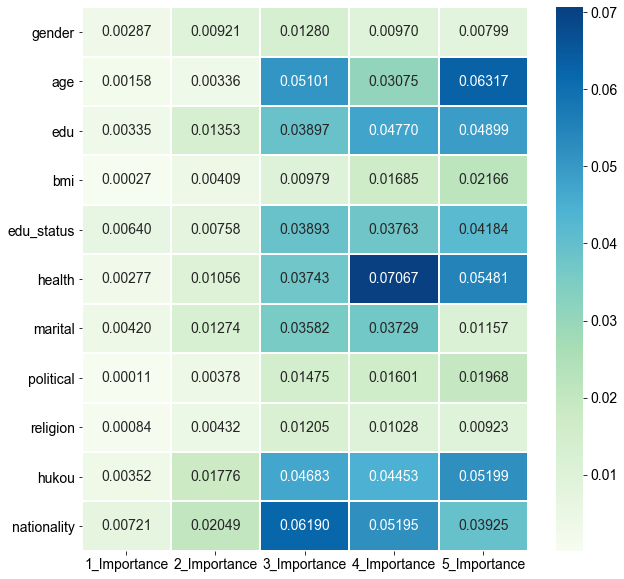

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['font.size'] = '14' 
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深-value个人.png",dpi=300)

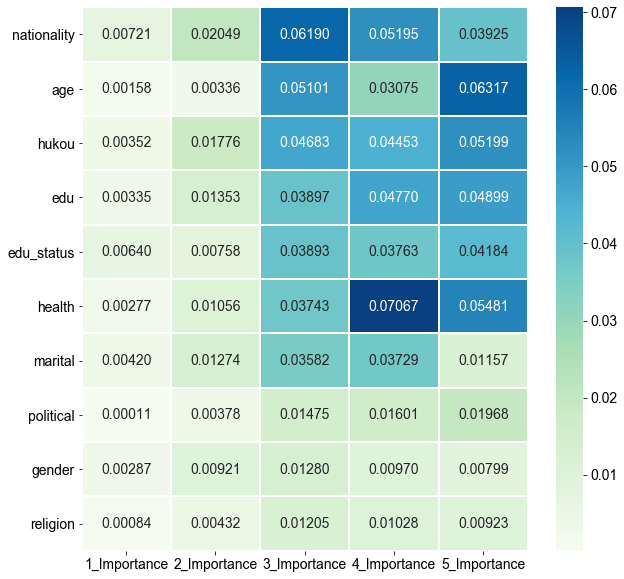

In [150]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:10]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深value_排序前10个个人.png",dpi=300)

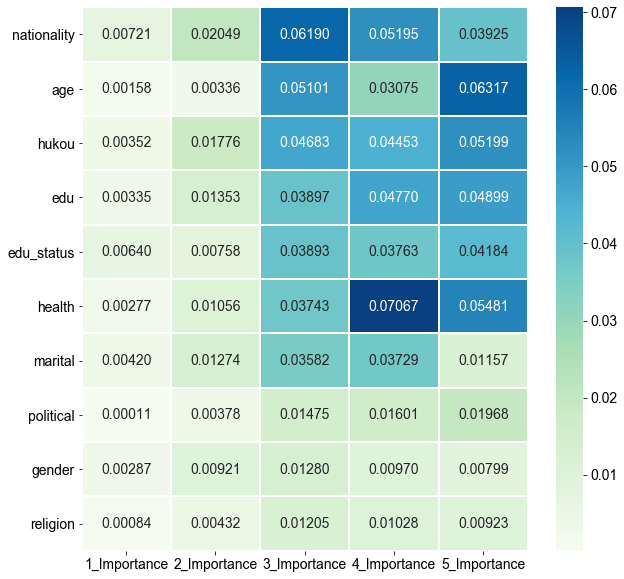

In [152]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:10]
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = '14' 
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.12宽深value_排序前10个个人大字.pdf",dpi=300)

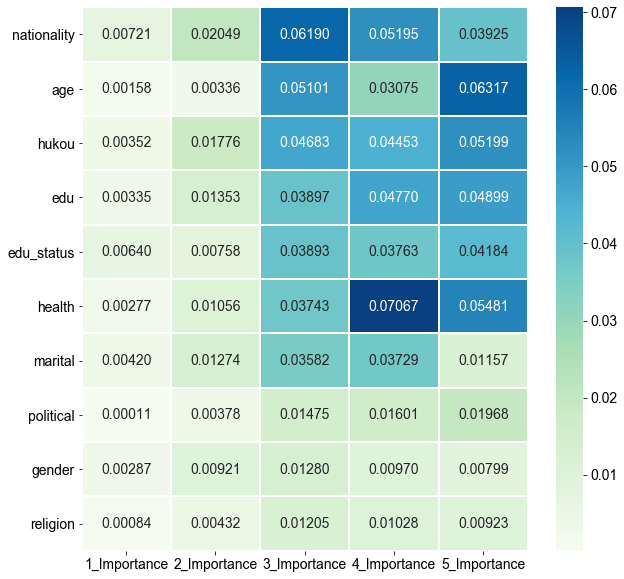

In [153]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:10]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深value_排序前10个个人.pdf",dpi=300)

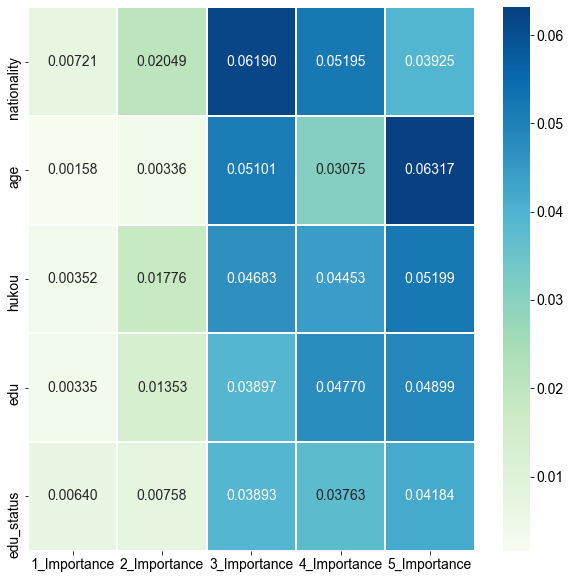

In [155]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:5]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.12宽深value_排序前5个个人.png",dpi=300)

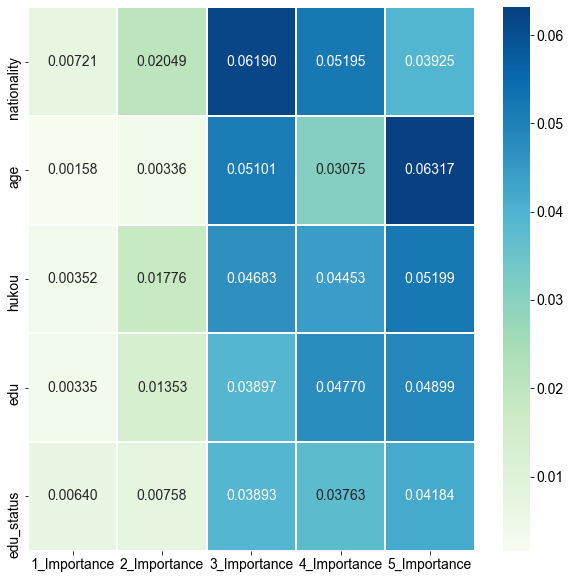

In [156]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:5]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.12宽深value_排序前5个个人.pdf",dpi=300)

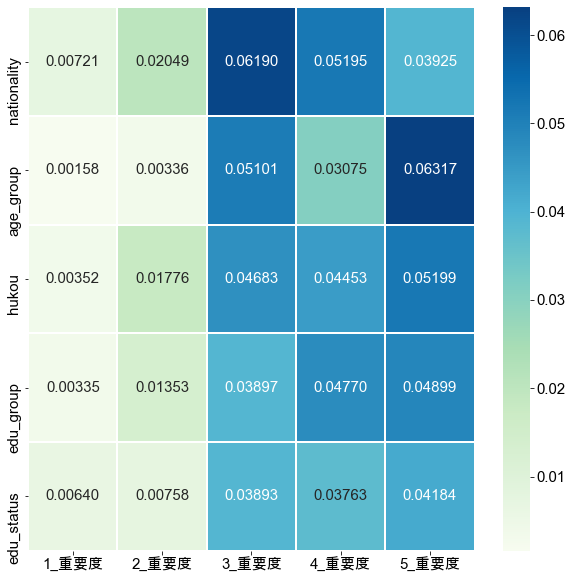

In [126]:
dfnew=dfnew.sort_values(by="3_重要度",ascending=False)
dfnew=dfnew[:5]
plt.figure(figsize=(10,10))

sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深value_排序前5个个人大字.pdf",dpi=300)